In [53]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import torch
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from string import punctuation

## Data preprocessing

In [54]:
# Load dataset
df = pd.read_csv("./IMDB Dataset.csv")
# Dataset is made of "review" and "sentiment"

In [55]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [56]:
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [57]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [58]:
# Remove the duplicates because they are quite certainly errors or double 
# insertions. Even worse if the same review has tewo different sentiments.
df = df.drop_duplicates()

In [59]:
df.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


In [60]:
# Every review is transformed to lowercase
df.review = df.review.apply(lambda x: x.lower())

In [61]:
df.head(5)

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


In [62]:
# Remove HTML
df.review = df.review.apply(lambda x: BeautifulSoup(x).get_text()) 

/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [63]:
# Remove punctuation
df.review = df.review.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation))) 

In [64]:
df.head(5)

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


In [65]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/greta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [66]:
# Tokenize the reviews
df.review = df.review.apply(lambda x: nltk.word_tokenize(x)) 

In [67]:
df.head(5)

,review,sentiment
0,"[one, of, the, other, reviewers, has, mentione...",positive
1,"[a, wonderful, little, production, the, filmin...",positive
2,"[i, thought, this, was, a, wonderful, way, to,...",positive
3,"[basically, theres, a, family, where, a, littl...",negative
4,"[petter, matteis, love, in, the, time, of, mon...",positive


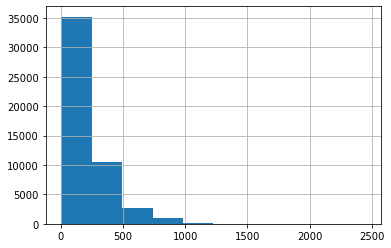

count    49582.000000
mean       226.529890
std        167.886738
min          4.000000
25%        124.000000
50%        170.000000
75%        275.000000
max       2450.000000
dtype: float64

In [68]:
# Anlaysis on reviews' length
lengths = [len(i) for i in df.review]
pd.Series(lengths).hist()
plt.show()
pd.Series(lengths).describe()

In [69]:
# Split dataset in postive and negative for analysis
positive_df = df[df['sentiment'] == 'positive'] 
negative_df = df[df['sentiment'] == 'negative'] 

In [70]:
positive_df.describe()

,review,sentiment
count,24884,24884
unique,24884,1
top,"[one, of, the, other, reviewers, has, mentione...",positive
freq,1,24884


In [71]:
negative_df.describe()

,review,sentiment
count,24698,24698
unique,24696,1
top,"[this, movie, got, off, to, an, interesting, s...",negative
freq,2,24698


In [72]:
df.describe()

,review,sentiment
count,49582,49582
unique,49580,2
top,"[this, is, yet, another, pseudointellectual, l...",positive
freq,2,24884


In [73]:
# Word analyisis 
postive_words_with_stop_words = positive_df.review.tolist()
postive_words_with_stop_words = [item for sublist in postive_words_with_stop_words for item in sublist]
negative_df_with_stop_words = negative_df.review.tolist()
negative_df_with_stop_words = [item for sublist in negative_df_with_stop_words for item in sublist]
words_with_stop_words = df.review.tolist()
words_with_stop_words = [item for sublist in words_with_stop_words for item in sublist]

In [74]:
print("Number of words with stop words in the postive dataset " + str(len(postive_words_with_stop_words)))
print("Number of words with stop words in the negative dataset " + str(len(negative_df_with_stop_words)))
print("Number of words with stop words in the entire dataset " + str(len(words_with_stop_words)))

Number of words with stop words in the postive dataset 5684242
Number of words with stop words in the negative dataset 5547563
Number of words with stop words in the entire dataset 11231805


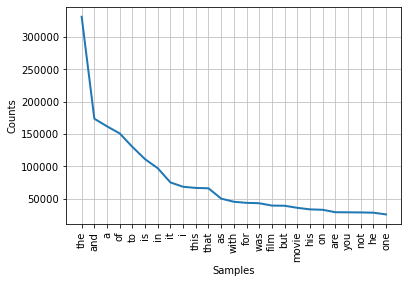

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [75]:
# Analysis of word frequency
data_analysis = nltk.FreqDist(postive_words_with_stop_words)
data_analysis.plot(25, cumulative=False)

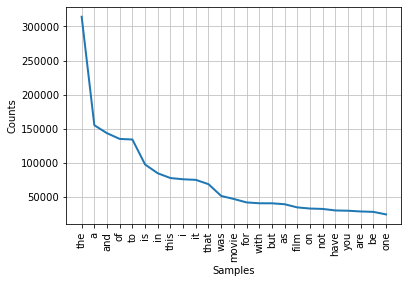

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [76]:
data_analysis = nltk.FreqDist(negative_df_with_stop_words)
data_analysis.plot(25, cumulative=False)

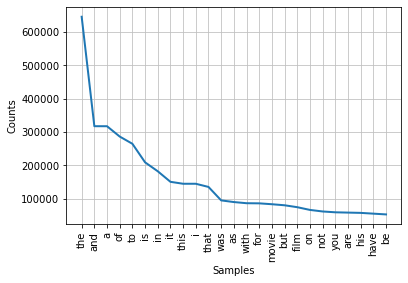

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [77]:
data_analysis = nltk.FreqDist(words_with_stop_words)
data_analysis.plot(25, cumulative=False)

This analysis is heavily influenced by the presence of stop words, that, as we can see from the plot, are very noisy and frequent. So, the next step is to remove them.

In [78]:
# Create stopwords set
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
# This stop word could be important in sentences like "not good"
stop_words = stop_words - {'not', "aren't", "couldn't", "didn't", "don't", \
                   "hadn't", "hasn't", "isn't"}

[nltk_data] Downloading package stopwords to /Users/greta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [79]:
# Remove stopwords
df.review = df.review.apply(lambda x: [item for item in x if item not in stop_words]) # Remove stop words

In [80]:
# Stemming
ps = PorterStemmer()
df.review = df.review.apply(lambda x: [ps.stem(word) for word in x]) 

In [81]:
# Split dataset for analysis
positive_df = df[df['sentiment'] == 'positive'] 
negative_df = df[df['sentiment'] == 'negative'] 

In [82]:
positive_df.describe()

,review,sentiment
count,24884,24884
unique,24882,1
top,"[film, easili, rival, emot, strength, dramat, ...",positive
freq,2,24884


In [83]:
negative_df.describe()

,review,sentiment
count,24698,24698
unique,24696,1
top,"[movi, got, interest, start, road, howev, stor...",negative
freq,2,24698


In [84]:
df.describe()

,review,sentiment
count,49582,49582
unique,49578,2
top,"[im, not, biggest, fan, western, two, person, ...",positive
freq,2,24884


In [85]:
# Dataframe to list and list of reviews to list of list of words
# this is useful for frequency analysis 
postive_words_without_stop_words = positive_df.review.tolist()
postive_words_without_stop_words = [item for sublist in postive_words_without_stop_words for item in sublist]
negative_df_without_stop_words = negative_df.review.tolist()
negative_df_without_stop_words = [item for sublist in negative_df_without_stop_words for item in sublist]
words_without_stop_words = df.review.tolist()
words_without_stop_words = [item for sublist in words_without_stop_words for item in sublist]

In [86]:
print("Number of words with stop words in the postive dataset " + str(len(postive_words_without_stop_words)))
print("Number of words with stop words in the negative dataset " + str(len(negative_df_without_stop_words)))
print("Number of words with stop words in the entire dataset " + str(len(words_without_stop_words)))

Number of words with stop words in the postive dataset 3046575
Number of words with stop words in the negative dataset 2961540
Number of words with stop words in the entire dataset 6008115


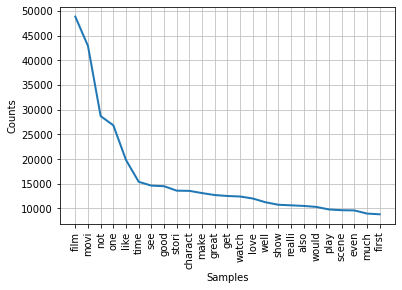

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [87]:
data_analysis = nltk.FreqDist(postive_words_without_stop_words)
data_analysis.plot(25, cumulative=False)

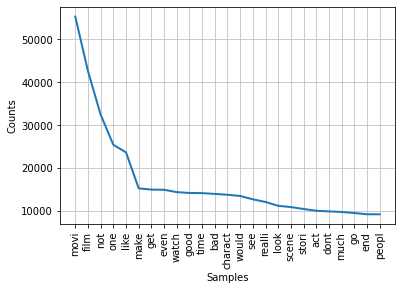

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [88]:
data_analysis = nltk.FreqDist(negative_df_without_stop_words)
data_analysis.plot(25, cumulative=False)

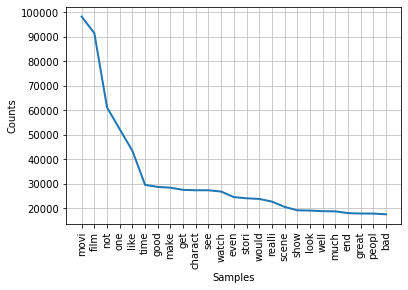

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [89]:
# Get words frequency
data_analysis = nltk.FreqDist(words_without_stop_words)
data_analysis.plot(25, cumulative=False)

In [90]:
# Base for dictionary word-frequency 
data_analysis

FreqDist({'movi': 98196, 'film': 91433, 'not': 61139, 'one': 52254, 'like': 43459, 'time': 29551, 'good': 28699, 'make': 28379, 'get': 27498, 'charact': 27339, ...})

In [91]:
# Order from most common words to least common ones
embed_dict = data_analysis.most_common()

# Embedding dictionary starting from 1 because 0 is for padding
embed_dict = {w:i+1 for i, (w,c) in enumerate(embed_dict)}

In [92]:
# Embedding: word to int 
reviews = df.review.tolist()
sentiments = df.sentiment.tolist()
sentiments_embedded = [1 if label =='positive' else 0 for label in sentiments]

reviews_embedded = []
for review in reviews:
  temp_list = []
  for word in review:
    temp_list.append(embed_dict[word])
  reviews_embedded.append(temp_list)

In [93]:
def trim_n_pad(reviews_int, seq_length):
    ''' Takes the list of reviews and trims each one of them to seq_length,
        if, the sequence it is not long enough, it will be padded with 0.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [94]:
# Keep just the first 200 words for a review
seq_len = 200
reviews_embedded = trim_n_pad(reviews_embedded, seq_len)

## Split dataset

In [95]:
# Split dataset
review_train, review_test, sentiment_train, sentiment_test = train_test_split(reviews_embedded, sentiments_embedded, stratify = sentiments_embedded)

In [96]:
print("Number of reviews train:", len(review_train))
print("Number of reviews test:", len(review_test))
print("Number of sentiment train:", len(sentiment_train))
print("Number of sentiment test:", len(sentiment_test))

pos_train = sentiment_train.count(1)
pos_test = sentiment_test.count(1)

print("Positive % on train", pos_train/len(sentiment_train))
print("Positive % on test", pos_test/len(sentiment_test))

Number of reviews train: 37186
Number of reviews test: 12396
Number of sentiment train: 37186
Number of sentiment test: 12396
Positive % on train 0.5018824288710805
Positive % on test 0.5018554372378187


In [97]:
# Removing outliers
review_train = [ review_train[i] for i in range(len(review_train)) if len(review_train[i])>0 ]
sentiment_train = [ sentiment_train[i] for i in range(len(review_train)) if len(review_train[i])>0 ]

# Removing outliers
review_test = [ review_test[i] for i in range(len(review_test)) if len(review_test[i])>0 ]
sentiment_test = [ sentiment_test[i] for i in range(len(review_test)) if len(review_test[i])>0 ]


## Dataloaders and Batching

In [98]:
# Create array with numpy
review_train = np.array(review_train)
sentiment_train = np.array(sentiment_train)

review_test = np.array(review_test)
sentiment_test = np.array(sentiment_test)

In [99]:
# Create Tensor datasets
train_data = TensorDataset(torch.from_numpy(review_train), torch.from_numpy(sentiment_train))
test_data = TensorDataset(torch.from_numpy(review_test), torch.from_numpy(sentiment_test))

In [100]:
# Define batch size
batch_size = 50

In [101]:
# Data loader
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

# If drop_last == True -> if the batch is not long enough, drop it

In [103]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[ 6596,    86,   435,  ...,   262,     8,     2],
        [    0,     0,     0,  ...,   147,     4,   236],
        [    0,     0,     0,  ...,   183,   173,  3244],
        ...,
        [    0,     0,     0,  ...,  2416,   691,   124],
        [ 1200,   320,   119,  ...,    38,   327,   767],
        [   66,   184,  9416,  ..., 18302,  1849, 21677]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 1])


## Define the model class

In [104]:
train_on_gpu = False


In [105]:

class SentimentLSTM(nn.Module):
    """
    The LSTM model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.3):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.25)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        # contiguos returns the same tensor but without empty cells, if any
        # view returns a new tensor with the same data as the self tensor 
        # but of a different shape, with -1 the size is inferred 
        # from other dimensions
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            mps_device = torch.device("mps")
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(mps_device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(mps_device))
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [106]:
# Instantiate the model w/ hyperparams
vocab_size = len(embed_dict)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 150
hidden_dim = 256
n_layers = 3
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

SentimentLSTM(
  (embedding): Embedding(182527, 150)
  (lstm): LSTM(150, 256, num_layers=3, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [107]:
# loss and optimization functions
lr=0.001

# Use BCE as cost function because the output is binary
criterion = nn.BCELoss()
# Use Adam as optimization technique
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# training params
epochs = 6 
clip = 5 # gradient clipping

counter = 0
print_every = 100

# move model to GPU, if available
if(train_on_gpu):
    mps_device = torch.device("mps")
    net.to(mps_device)

# Set the net in training mode -> the dropout layers act as dropout
net.train() 

# Train
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.to(mps_device), labels.to(mps_device)
        else:
            inputs = inputs.type(torch.LongTensor)

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # Clear the gradient at each iteration beacuse of batching
        # otherwise, the gradient would be a combination of the old gradient, 
        # which you have already used to update your model parameters, 
        # and the newly-computed gradient. 
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h) 

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward() # Computes the gradient of current tensor

        # 'clip_grad_norm' helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()))

KeyboardInterrupt: 

In [ ]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

# Set the net to eval mode -> dropout layers implement now the identity function
net.eval()

# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.to(mps_device), labels.to(mps_device)
    else:
        inputs = inputs.type(torch.LongTensor)
      
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.425
Test accuracy: 0.856


In [ ]:

def tokenize_review(test_review):
    # lowercase
    test_review = test_review.lower() 
    # get rid of punctuation
    test_text = ''.join([c for c in test_review if c not in punctuation])

    # tokenize
    test_words = test_text.split()

    # Remove stop words
    test_words = [item for item in test_words if item not in stop_words] 
    # Stemming
    test_words = [ps.stem(word) for word in test_words]

    # Create list of tokens
    test_ints = []
    test_ints.append([embed_dict[word] for word in test_words])

    return test_ints


def predict(net, test_review, sequence_length=200):
    
    net.eval()
    
    # tokenize review
    test_ints = tokenize_review(test_review)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = trim_n_pad(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    # initialize hidden state
    h = net.init_hidden(batch_size)
    
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()
    
    # get the output from the model
    output, h = net(feature_tensor, h)
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze()) 
    # printing output value, before rounding
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    
    # print custom response
    if(pred.item()==1):
        print("Positive review detected!")
    else:
        print("Negative review detected.")
        

In [ ]:
test_review = 'This film sucks, the actors are terrible and the plot is awful.'
seq_length=200
predict(net, test_review, seq_length)

Prediction value, pre-rounding: 0.001823
Negative review detected.


In [ ]:
test_review = 'This movie has the best acting, I loved it.'
seq_length=200
predict(net, test_review, seq_length)

Prediction value, pre-rounding: 0.979462
Positive review detected!
